In [1]:
from datasets import wine_red_dataset
import pandas as pd
wine_red = wine_red_dataset()
wine_red.dropna(how='all', inplace=True)

# Feature selection

## VIF

When a model is trained with colinear features, the coefficients (weights) tend to depend on each other which reduces explanability of the model. Find features that have high colinearity. 

Variance Inflation Factor, measures how much the variance of an estimated regression coefficient is increased because of collinearity

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
x = wine_red.dropna().drop('quality', axis=1).drop('ID', axis=1)
vif_factors = pd.Series([variance_inflation_factor(x.values, i) for i in range(x.shape[1])], index=x.columns)

display(vif_factors)

fixed acidity                2.314030
volatile acidity             1.741720
citric acid                  3.132193
residual sugar               1.125396
chlorides                    1.364200
flavanoids              139849.177083
free sulfur dioxide          1.930893
total sulfur dioxide         2.104990
density                      1.653583
pH                           1.004598
sulphates                    1.346137
magnesium                    1.004227
alcohol                     10.631516
lightness                    9.929243
dtype: float64

=> alcohol and lightness seem to have high colinearity

In [3]:
wine_red['alcohol'].corr(wine_red['lightness'])

-0.9478388402404578

alcohol and lightness have high negative correlation

In [4]:
x = wine_red.dropna().drop('quality', axis=1).drop('lightness',axis=1).drop('ID', axis=1)
vif_factors = pd.Series([variance_inflation_factor(x.values, i) for i in range(x.shape[1])], index=x.columns)

display(vif_factors)

fixed acidity                2.314014
volatile acidity             1.741515
citric acid                  3.130305
residual sugar               1.125355
chlorides                    1.361599
flavanoids              132957.699251
free sulfur dioxide          1.925508
total sulfur dioxide         2.095232
density                      1.648418
pH                           1.004597
sulphates                    1.341383
magnesium                    1.004135
alcohol                      1.679509
dtype: float64

when removing lightness as a feature, the colinearity disappears

## Information Gain

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import numpy as np

wine_red_nan = wine_red.dropna()
x = wine_red_nan.drop('ID', axis=1).drop('quality', axis=1)
y = wine_red_nan['quality']

def get_kbest_sorted(selector,x,y):
    flt = SelectKBest(selector).fit(x,y)
    scores = flt.scores_
    best_features = pd.DataFrame(scores,index=x.columns, columns=['score'])
    for i in range(1,25):
        np.random.seed(i)
        flt = SelectKBest(selector).fit(x,y)
        scores = flt.scores_
        df = pd.DataFrame(scores,index=x.columns, columns=['score'])
        best_features = df + best_features
    best_features = best_features / i
    best_features = best_features.sort_values(by=['score'], ascending=False)
    return best_features

#filtering using Mutual Information = Information Gain
kbest_mutual_info_regression = get_kbest_sorted(mutual_info_regression, x, y)

display(kbest_mutual_info_regression)

,score
alcohol,0.182415
lightness,0.124717
volatile acidity,0.115468
sulphates,0.109905
total sulfur dioxide,0.083356
citric acid,0.064007
fixed acidity,0.049970
chlorides,0.029124
density,0.025616
free sulfur dioxide,0.025417


The mutual_info_regression selector is dependent on random state, which is different every execution. Because of this condition we calculate a mean over 25 iterations to have a more secure output

we could delete following features:
- chlorides
- density
- free sulfur dioxide
- residual sugar
- pH
- magnesium
- flavanoids

We could also merge them into one feature

## Correlation

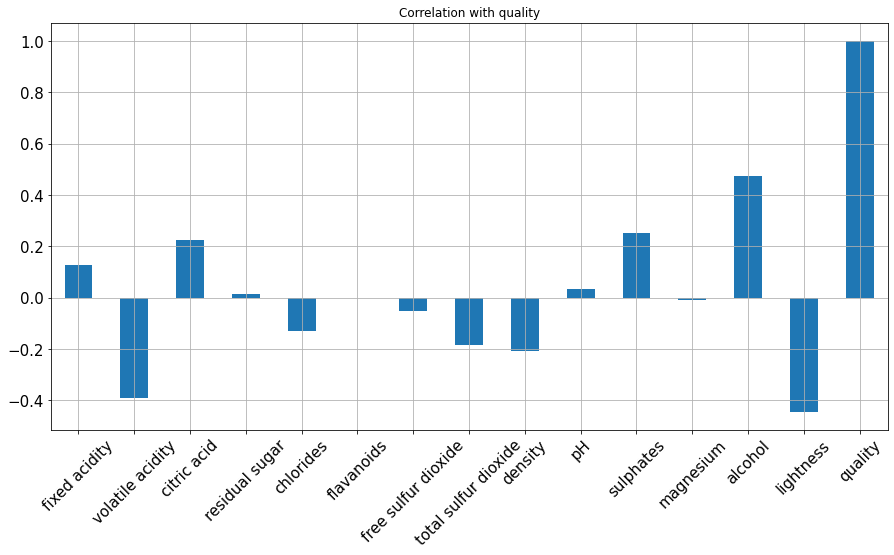

In [46]:
wine_red.drop('ID', axis=1).corrwith(wine_red['quality']).plot.bar(
        figsize = (15, 7.5), title = "Correlation with quality", fontsize = 15,
        rot = 45, grid = True)

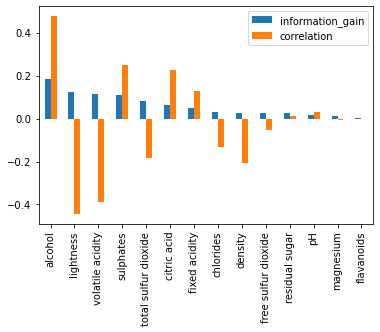

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Build new DataFrame for information gain and correlation side by side
corr = wine_red.drop('ID', axis=1).corrwith(wine_red['quality'])
features = kbest_mutual_info_regression.index
values = []
for feature in features:
    # access correct values by index
    values.append([kbest_mutual_info_regression.loc[feature,'score'], corr[feature]])
df = pd.DataFrame(values, columns=['information_gain', 'correlation'], index=features)
df.plot.bar()

plt.show()

## Correlating Features

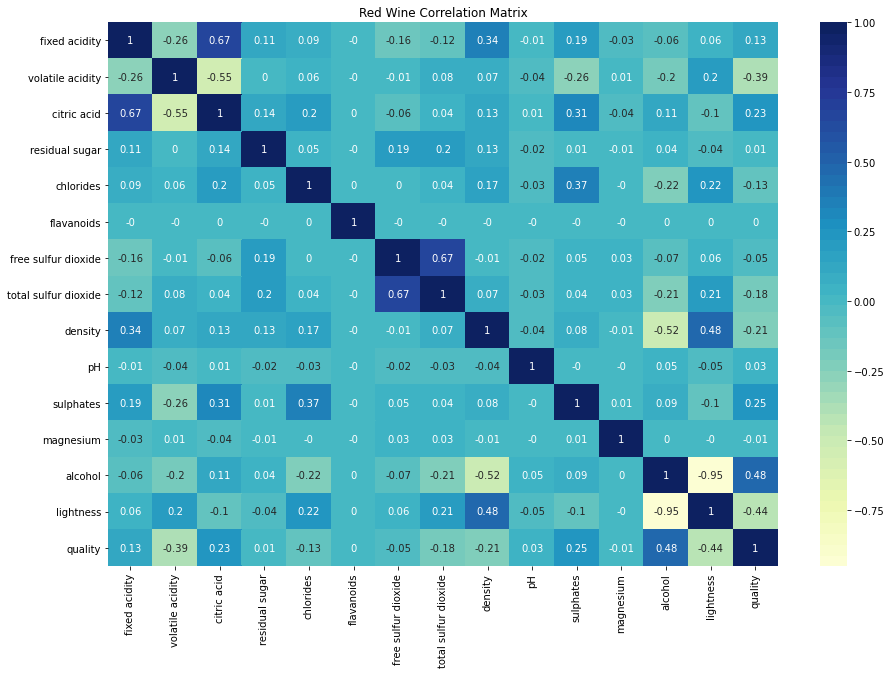

In [89]:
import seaborn as sns
correlations = round(wine_red.drop('ID', axis=1).corr(), 2)
plt.figure(figsize = (15, 10))
ax = sns.heatmap(correlations, annot=True, cmap = sns.color_palette("YlGnBu", 50))
ax.axes.set_title("Red Wine Correlation Matrix")
plt.show()

In [ ]:
Flavanoids have a constant value across all data. This leads to a variance of zero and hence an undefined correlation with other features, since division by zero is not possible.

Highest correlating features:
- fixed acidity / citric acid 0.67
- free sulfur dioxide / total sulfur dioxide 0.67
- lightness / density 0.48
- density / fixed acidity 0.34

most negatively correlating features:
- alcohol / lightness -0.95
- volatile acidity / citric acd -0.55
- alcohol / density -0.52

## Summary
- use alcohol as the major feature, lightness and density have high correlation with it, so it's even better to remove both
- remove lightness because it is highly colinear with alcohol
- use sulphates as a feature
- use citric acid as a feature, it also correlates with fixed acidity. This is why fixed acidity should be removed.
- volatice acidity and citric acid have relatively high correlation. remove volatile acidity or keep both.
- use chlorides as a feature
- remove all other features

# Instance selection

# Feature reduction